<h1> BLOOD DONATION PREDICTION </h1> 

This is a competition project on Blood Donation Prediction. 
The goal is to predict whether patient will give blood in March 2007. 

Use information about each donor's history 
<ul>
   <li> Months since Last Donation: this is the number of monthis since this donor's most recent donation. </li>
   <li> Number of Donations: this is the total number of donations that the donor has made.  </li>
   <li> Total Volume Donated: this is the total amound of blood that the donor has donated in cubuc centimeters. </li>
   <li>  Months since First Donation: this is the number of months since the donor's first donation. </li>
</ul>

The data is from <a href="https://archive.ics.uci.edu/ml/datasets/Blood+Transfusion+Service+Center">UCI Machine Learning Repository</a>
The competition is hosted by  <a href="https://www.drivendata.org/competitions/2/warm-up-predict-blood-donations/page/5/">DrivenData.org </a> 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

training = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data', 
                       skipinitialspace=True )
training.columns = ['MonthsLastDonation', 'NumDonations', 'TotalVolume', 'MonthsFirstDonation', 'MadeDonation']
training['MadeDonation'] = training['MadeDonation'].astype('category')
training.info()
training.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
MonthsLastDonation     748 non-null int64
NumDonations           748 non-null int64
TotalVolume            748 non-null int64
MonthsFirstDonation    748 non-null int64
MadeDonation           748 non-null category
dtypes: category(1), int64(4)
memory usage: 24.3 KB


,MonthsLastDonation,NumDonations,TotalVolume,MonthsFirstDonation
count,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086
std,8.095396,5.839307,1459.826781,24.376714
min,0.000000,1.000000,250.000000,2.000000
25%,2.750000,2.000000,500.000000,16.000000
50%,7.000000,4.000000,1000.000000,28.000000
75%,14.000000,7.000000,1750.000000,50.000000
max,74.000000,50.000000,12500.000000,98.000000


There seems to be no missing value but the data's ranges are quite different from each other. We might need some scaler since most classifiers would need predictors to be in the same magnitude. 

<h1> Exploratory Data Analysis </h1>

It looks like NumDonations and TotalVolume is perfectly correlated. With further investigation, one can see TotalVolume/NumDonations = 250cc. In other words, for every time patients donate blood, 250cc is donated. Therefore, either one can be chosen for final model. NumDonations is chosen in this case.

Also, the KDE plot for months since first donation and months since last seem to overlap, which mean using both variables to predict is redundant. We can compute tenure i.e. how long a person has been donating blood; then drop the months since first donated. 

Looking at the relationships between target variable and predictors, logistic regression does not seem like a good idea since both classes are quite similar. 

Last, the class of target is imbalanced in this case as shown in the table after the pairplot. We might need some stratification when sampling later. 

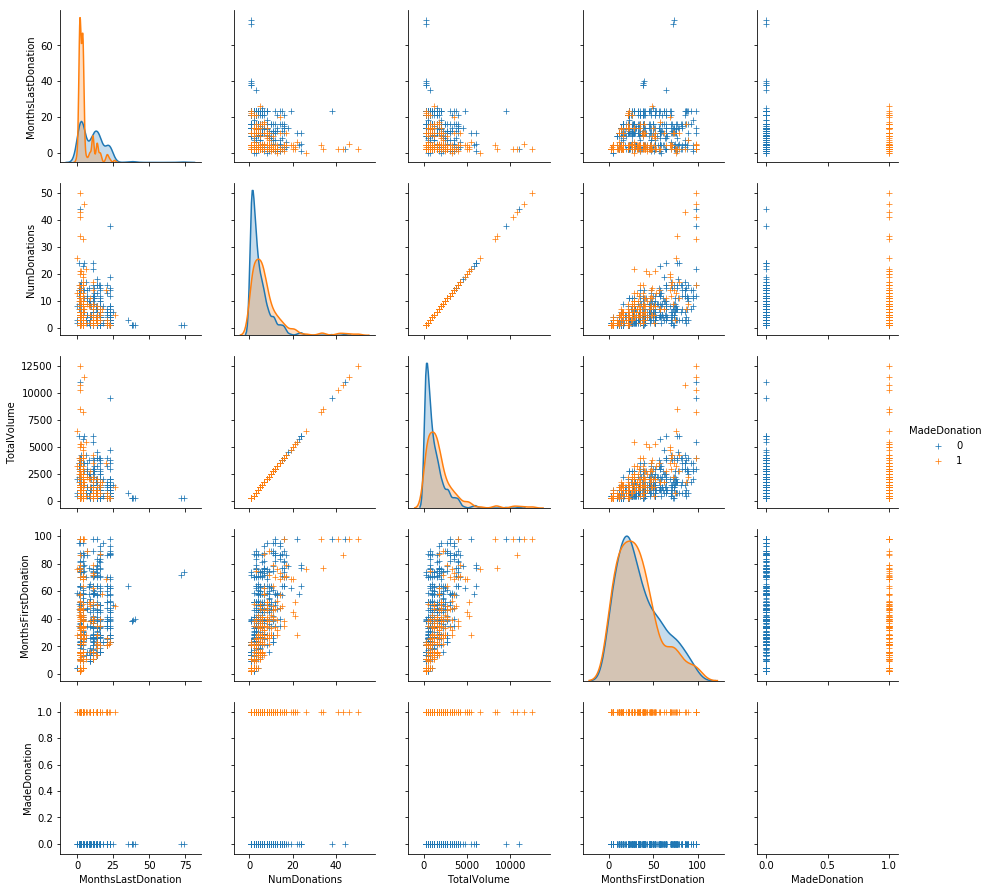

,MonthsLastDonation,NumDonations,TotalVolume,MonthsFirstDonation
MadeDonation,,,,
0,570,570,570,570
1,178,178,178,178


In [31]:
sns.pairplot(training, hue ='MadeDonation', diag_kind="kde", markers="+")
np.seterr(divide='ignore', invalid='ignore')
plt.show()
training.groupby('MadeDonation').count()

Examining the correlation matrix, we can see NumDonations also have correlation with MonthsFirstDonation. 

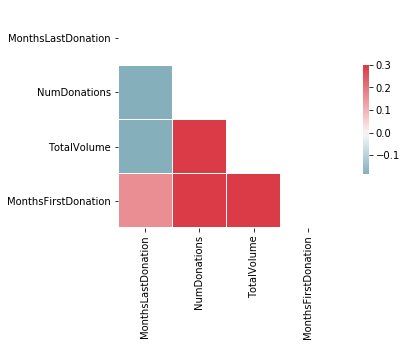

In [32]:
corr = training.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 4))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

<h1> Transformation </h1>

We will build a function that can transform new data to the form we need. First columns are renamed, then tenure is calculated, then we will drop some redundant features and return the predictors.  

In [137]:
predictors = training.iloc[:,:4]
target = training.iloc[:,4]

def transf(features):
    features.columns = ['MonthsLastDonation', 'NumDonations', 'TotalVolume', 'MonthsFirstDonation']
    
    features.loc[features.MonthsFirstDonation != 0, 'newbie'] = 0
    features.loc[features.MonthsFirstDonation == 0, 'newbie'] = 1
    
    #calculating tenure
    features['tenure'] = features['MonthsFirstDonation'] - features['MonthsLastDonation']

    
    #drop features
    features.drop(['TotalVolume', 'MonthsFirstDonation'], axis = 1, inplace = True)
    return features

transf(predictors)
predictors.head()

,MonthsLastDonation,NumDonations,newbie,tenure
0,2,50,0.0,96
1,0,13,0.0,28
2,1,16,0.0,34
3,2,20,0.0,43
4,1,24,0.0,76


<h1> Modelling </h1>

In this part, after testing multiple models including logistic regression, K-nearest neighbors, linear SVM, multi-layer perceptrons (NN) and GBC; NN and GBC stand out as promising with lowest log_loss and highest accuracy. Ensembling model was also experimented but results was not much better than NN alone. 

For sampling strategy, we will separate 10% of data as hold out (with stratify) and use 90% to perform Grid search cross validation. Since GridSearchCV has stratified K-fold CV built in we don't need to specify in the function. 

The following code is for the NN model:


In [138]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score

#splitting data
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.1, random_state=48, 
                                                    shuffle = True, stratify = target)

#building pipeline
 
pipe = Pipeline([('scaler', StandardScaler()),
                 ('NN', MLPClassifier(solver='sgd', max_iter = 3000))
                ])
    
param_grid = [{
    'NN__alpha': 10.0 ** -np.arange(1, 7),
    'NN__hidden_layer_sizes': [(150,25), (175,25)],
}]



This part is for the GBC model:


In [91]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size = 0.1, random_state=48, 
                                                    shuffle = True, stratify = target)
pipe = Pipeline([('scaler', StandardScaler()),
                 ('GBC',GradientBoostingClassifier(max_leaf_nodes = 4, 
                                                   max_depth = None, random_state=2,min_samples_split= 5, 
                                                   subsample = 0.5) )
                ])

param_grid = {
    'GBC__n_estimators': range(100,500, 50),
    'GBC__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
}


Okay let's train the model. We use Grid search cross validation to tune our hyper parameters and use negative log loss in our search to find the best model. 


In [116]:
model = GridSearchCV(pipe, cv = 10, 
                           param_grid=param_grid ,n_jobs = -1, scoring = 'neg_log_loss')
model.fit(X_train, y_train)
    
print(model.best_params_)
print(model.best_score_)
 

{'NN__alpha': 0.0001, 'NN__hidden_layer_sizes': (150, 25)}
-0.47490310167


Let's test the model on the hold-out set.

In [139]:
y_pred_prob = model.predict_proba(X_test) 
print(log_loss(y_test,y_pred_prob))

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.45599753815
0.786666666667


Let's save the model and print out the submission results in specified format. 

In [140]:
import pickle
pkl_filename = "NN6.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

In [141]:

with open("NN6.pkl", 'rb') as file:  
    load_model = pickle.load(file)

In [142]:
submission = pd.read_csv('https://s3.amazonaws.com/drivendata/data/2/public/5c9fa979-5a84-45d6-93b9-543d1a0efc41.csv', 
                         index_col = 'Unnamed: 0',skipinitialspace=True )
submission = transf(submission)
submission_results = load_model.predict_proba(submission)
submission_results = pd.DataFrame(submission_results[:,1], index = submission.index)
submission_results.columns = ['Made Donation in March 2007']
submission_results.to_csv('submission_6.csv')